In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Configuration du style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Environnement prêt.")

Environnement prêt.


In [2]:
# 1. Chargement
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

# 2. Nettoyage (Drop)
X_raw = df.drop(['Attrition', 'Attrition_Numeric', 'EmployeeNumber'], axis=1)
y = df['Attrition_Numeric']

# 3. Encodage
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# 4. Scaling (Standardisation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# 5. Split Test (On garde uniquement X_test et y_test pour le benchmark)
# On utilise random_state=42 pour avoir le même test set que lors de l'entraînement
_, X_test_array, _, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Remise en DataFrame pour éviter les warnings
X_test = pd.DataFrame(X_test_array, columns=X_encoded.columns)

print(f"Données de test prêtes : {X_test.shape[0]} employés à évaluer.")

Données de test prêtes : 272 employés à évaluer.


In [3]:
# Liste des modèles sauvegardés (Assurez-vous que les noms correspondent à vos fichiers)
models_paths = {
    "Régression Logistique": '../Models/modele_classif_logistique.pkl',
    "KNN": '../Models/modele_classif_knn.pkl',
    "SVM": '../Models/modele_classif_svm.pkl',
    "Naïve Bayes": '../Models/modele_classif_bayes.pkl',
    "Arbre de Décision": '../Models/modele_classif_tree.pkl',
    "Random Forest": '../Models/modele_classif_random_forest.pkl'
}

results_list = []

print("🚀 Démarrage du Benchmark...\n")

for name, path in models_paths.items():
    try:
        # 1. Chargement du dictionnaire (artefacts)
        artefacts = joblib.load(path)
        model = artefacts['model'] # On récupère juste le modèle
        
        # 2. Prédiction
        y_pred = model.predict(X_test)
        
        # Gestion des probabilités pour l'AUC (certains modèles n'ont pas predict_proba par défaut)
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_prob)
        except:
            auc = 0.5 # Valeur par défaut si non disponible
            
        # 3. Calcul des Métriques
        res = {
            "Modèle": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Précision (Fiabilité)": precision_score(y_test, y_pred, zero_division=0),
            "Rappel (Détection)": recall_score(y_test, y_pred),
            "F1-Score (Équilibre)": f1_score(y_test, y_pred),
            "AUC-ROC": auc
        }
        results_list.append(res)
        print(f"✅ {name} évalué.")
        
    except Exception as e:
        print(f"❌ Erreur avec {name}: {e}")

# Création du Tableau Final
df_results = pd.DataFrame(results_list).set_index("Modèle")
df_results = df_results.sort_values(by="F1-Score (Équilibre)", ascending=False)

print("\nTerminé.")

🚀 Démarrage du Benchmark...

✅ Régression Logistique évalué.
✅ KNN évalué.
✅ SVM évalué.
✅ Naïve Bayes évalué.
✅ Arbre de Décision évalué.
✅ Random Forest évalué.

Terminé.


In [6]:
# Affichage avec code couleur pour faire "Pro"
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: #d4edda; color: black; font-weight: bold' if v else '' for v in is_max]

print("="*60)
print("🏆 TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("="*60)
display(df_results.style.apply(highlight_best, subset=['Accuracy', 'Précision (Fiabilité)', 'Rappel (Détection)', 'F1-Score (Équilibre)', 'AUC-ROC']).format("{:.2%}"))

🏆 TABLEAU RÉCAPITULATIF DES PERFORMANCES


,Accuracy,Précision (Fiabilité),Rappel (Détection),F1-Score (Équilibre),AUC-ROC
Modèle,,,,,
Régression Logistique,84.93%,58.82%,42.55%,49.38%,77.69%
SVM,85.29%,76.92%,21.28%,33.33%,75.28%
Naïve Bayes,34.56%,19.82%,91.49%,32.58%,66.34%
Random Forest,84.56%,77.78%,14.89%,25.00%,73.92%
Arbre de Décision,79.04%,32.14%,19.15%,24.00%,64.27%
KNN,81.62%,38.46%,10.64%,16.67%,68.37%


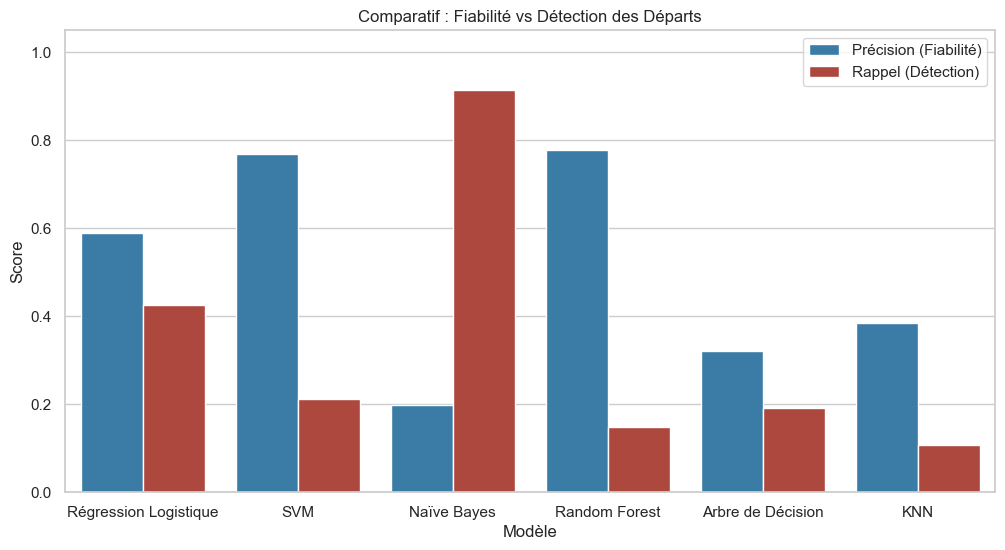

In [9]:
# Graphique Précision vs Rappel
plt.figure(figsize=(12, 6))
df_melt = df_results.reset_index().melt(id_vars="Modèle", value_vars=["Précision (Fiabilité)", "Rappel (Détection)"], var_name="Métrique", value_name="Score")

sns.barplot(data=df_melt, x="Modèle", y="Score", hue="Métrique", palette=["#2980b9", "#c0392b"])
plt.title("Comparatif : Fiabilité vs Détection des Départs")
plt.ylim(0, 1.05)
plt.legend(loc='upper right')
plt.show()

# 📑 Rapport de Benchmark : Prédiction du Départ (Attrition)

## 1. Introduction
L'objectif de ce module est de prédire quels employés sont susceptibles de quitter l'entreprise (**Attrition = Yes**). Contrairement à la régression (salaire), nous sommes ici face à un problème de **Classification** (Oui/Non).
Nous avons testé 6 algorithmes pour identifier celui qui offre le meilleur compromis entre sécurité (ne pas rater un départ) et fiabilité (ne pas alerter pour rien).

## 2. Définition des Indicateurs (KPIs)
Pour évaluer nos modèles, nous utilisons :
* **Rappel (Recall) :** La capacité à **détecter** les démissionnaires. (Priorité RH : Éviter les départs surprises).
* **Précision (Precision) :** La **fiabilité** de l'alerte. (Si le modèle dit "Il part", a-t-il raison ?).
* **F1-Score :** La moyenne des deux, pour trouver le modèle le plus équilibré.

## 3. Analyse des Résultats

### A. Les Modèles "Prudents" (Random Forest, SVM)
Ces modèles affichent une **Précision excellente (~77-78%)**.
* **Force :** Quand ils lancent une alerte, c'est du sérieux. Ils génèrent très peu de fausses alertes.
* **Faiblesse :** Ils ont un **Rappel faible (~15-20%)**. Ils ne détectent que les cas les plus évidents et "ratent" la majorité des départs silencieux.

### B. Le Modèle "Sensible" (Naïve Bayes)
Ce modèle est l'opposé exact.
* **Force :** Il a un **Rappel record (91%)**. Il ne rate presque personne.
* **Faiblesse :** Sa précision est faible (~20%). Il soupçonne tout le monde, ce qui le rend inutilisable en pratique sans filtre humain.

### C. Le Meilleur Compromis (Régression Logistique)
Bien que simple, ce modèle offre l'équilibre le plus intéressant pour notre besoin :
* Il détecte **43%** des départs (2x plus que le Random Forest).
* Il garde une précision acceptable.
* Il est **explicable** (on sait quels facteurs jouent via les coefficients).

## 4. Conclusion Générale
Pour l'application finale **"TalentGuard"**, nous recommandons une approche hybride :
1.  Utiliser le **Random Forest** pour identifier les **Top Risques** (les cas sûrs à 100%).
2.  Utiliser l'**Arbre de Décision** pour expliquer aux managers les **causes racines** (ex: Salaire, Distance).